In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import *
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  classification_report

# RNN Model Definition

In [2]:
class RNN(nn.Module):
    def __init__(self, vocabulary_size, num_classes, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Args:
        vocabulary_size (int): The size of the vocabulary (number of unique tokens in the input text).
        num_classes (int): The number of output classes (labels).
        embedding_dim (int): The dimension of the word embeddings (the vector size representing each word).
        hidden_dim (int): The number of units in the hidden state of the RNN.
        n_layers (int): The number of RNN layers to stack.
        dropout (float, optional): The probability for dropout regularization (default is 0.5).
        """
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        out, hidden = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

# Yangswei_85

To use the Yangswei_85 dataset, run the cell below.

In [8]:
# Load training set
df_train = pd.read_csv('data/train_yangswei_85.csv')  
# Load test set
test_df = pd.read_csv('data/test_yangswei_85.csv')
dataset_name = 'Yangswei_85'

# T5 
To use the T5 dataset, run the cell below.

In [ ]:

# Load training set
df_train = pd.read_csv('data/train_t5.csv')  
# Load test set
test_df = pd.read_csv('data/test_t5.csv')
dataset_name = 'T5'

# Training and Validation

## Training Data Preprocessing

In [4]:
#Preprocess training data
df_train['text'].apply(preprocess).to_frame()

# Tokenize and pad training data
padded_sequences, train_vocabulary, vocab_size = tokenize_and_pad(df_train[['text']].iloc[:2000])

# Set training data
train_data = padded_sequences

#Encode labels and save classes in npy file
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'].iloc[:2000])
np.save('data/label_classes.npy', label_encoder.classes_)
train_labels = torch.tensor(label_encoder.transform(df_train['label'].iloc[:2000]))

## Tune Hyperparameters

In [5]:
#Set fixed model parameters
epochs = 5 #20
num_classes = len(label_encoder.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_args = {
    'vocabulary_size': vocab_size,
    'num_classes': num_classes   
}

# Set the hyperparameters to tune
param_grid = {
    'embedding_dim': [100], # 200, 400
    'hidden_dim': [128], #256, 512
    'n_layers': [1], #2
    'dropout': [0.2], # 0.3, 0.5
    'learning_rate': [0.001] #, 0.01, 0.1
}

# Tune the model hyperparameters
best_params, best_accuracy = tune_hyperparams(RNN, model_args, train_data, train_labels, param_grid, epochs, device)
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy}")

# Set the best hyperparameters
embedding_dim, hidden_dim, n_layers, dropout, learning_rate = best_params.values()

Fold 1/2, Params: {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.2, 'learning_rate': 0.001}


/opt/anaconda3/envs/txa/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1/5, Train Loss: 1.4327, Val Loss: 1.2095, Val Acc: 0.5660
Epoch: 2/5, Train Loss: 1.2661, Val Loss: 1.1834, Val Acc: 0.5730
Epoch: 3/5, Train Loss: 1.2411, Val Loss: 1.1771, Val Acc: 0.5790
Epoch: 4/5, Train Loss: 1.2252, Val Loss: 1.1608, Val Acc: 0.5800
Epoch: 5/5, Train Loss: 1.1912, Val Loss: 1.1459, Val Acc: 0.5900
Fold 2/2, Params: {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.2, 'learning_rate': 0.001}


/opt/anaconda3/envs/txa/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 1/5, Train Loss: 1.4229, Val Loss: 1.2694, Val Acc: 0.5440
Epoch: 2/5, Train Loss: 1.1920, Val Loss: 1.2563, Val Acc: 0.5440
Epoch: 3/5, Train Loss: 1.1743, Val Loss: 1.2457, Val Acc: 0.5520
Epoch: 4/5, Train Loss: 1.1558, Val Loss: 1.2207, Val Acc: 0.5580
Epoch: 5/5, Train Loss: 1.1276, Val Loss: 1.2126, Val Acc: 0.5680
Best Parameters: {'embedding_dim': 100, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.2, 'learning_rate': 0.001}
Best Accuracy: 0.579


## Set model with best hyperparameters

In [6]:
rnn_model = RNN(vocab_size, num_classes, embedding_dim, hidden_dim, n_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

## Train and Validate best model

Start Training and Validation:

Epoch: 1/5, Train Loss: 1.3809, Val Loss: 1.1877, Val Acc: 0.5625
Epoch: 2/5, Train Loss: 1.2132, Val Loss: 1.1605, Val Acc: 0.5725
Epoch: 3/5, Train Loss: 1.1882, Val Loss: 1.1505, Val Acc: 0.5875
Epoch: 4/5, Train Loss: 1.1659, Val Loss: 1.1424, Val Acc: 0.5950
Epoch: 5/5, Train Loss: 1.1625, Val Loss: 1.1308, Val Acc: 0.5925


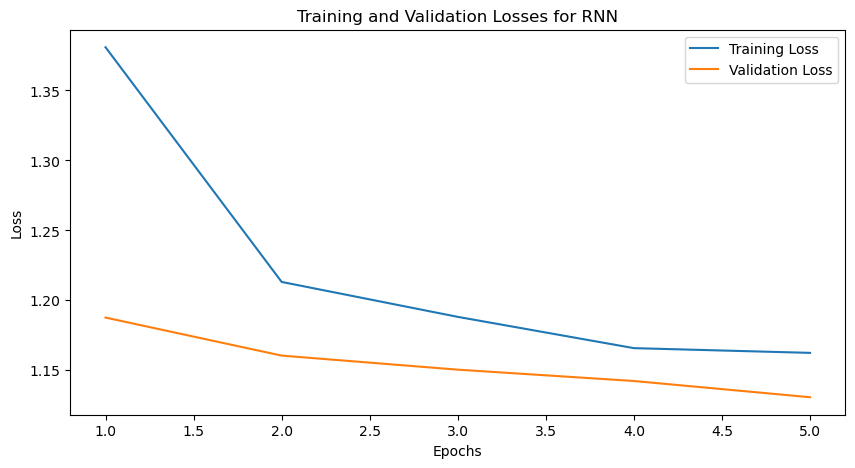

In [7]:
print("Start Training and Validation:\n")
# Split training data into training and validation sets
train_loader, val_loader = train_val_split(train_data, train_labels)

# Train and validate best model
train_losses, val_losses, val_accs, model = train_and_validate(
    rnn_model, optimizer, criterion, train_loader, val_loader, epochs, device
)

# Plot training and validation losses
plot_losses("RNN", dataset_name, train_losses, val_losses, epochs)


In [9]:
# Save best model configuration
model_config = {
    "vocab_size": vocab_size,
    "num_classes": num_classes,
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "n_layers": n_layers,
    "dropout": dropout,
    "state_dict": model.state_dict()
}

torch.save(model_config, "models/RNN.pth")

# Test

## Test Data Preprocessing

In [10]:
# Preprocess test data
test_df['text'].apply(preprocess).to_frame()  

# Tokenize and pad test data
padded_sequences, _, _ = tokenize_and_pad(test_df[['text']].iloc[:2000], train_vocabulary)

# Set test data
test_data = padded_sequences

#Encode test labels by loading encoder used for training labels
label_classes = np.load('data/label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
test_labels = torch.tensor(label_encoder.transform(test_df['label'].iloc[:2000]))

## Test best model on test data

In [11]:
# Wrap the test data in a DataLoader
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=128, shuffle=False)

#Load trained model
model_config = torch.load("models/RNN.pth")
model = RNN(model_config["vocab_size"], model_config["num_classes"], model_config["embedding_dim"], model_config["hidden_dim"],model_config["n_layers"], model_config["dropout"])  
model.load_state_dict(model_config["state_dict"])  
model.to(device)

#Test model on test set
predictions, true_labels = test(model, test_loader, device)

/opt/anaconda3/envs/txa/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Compute metrics on model performance

Test Accuracy: 0.6060
Macro Metrics

Macro Precision: 0.1010
Macro Recall: 0.1667
Macro F1 Score: 0.1258
Weighted Metrics

Weighted Precision: 0.3672
Weighted Recall: 0.6060
Weighted F1 Score: 0.4573


/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


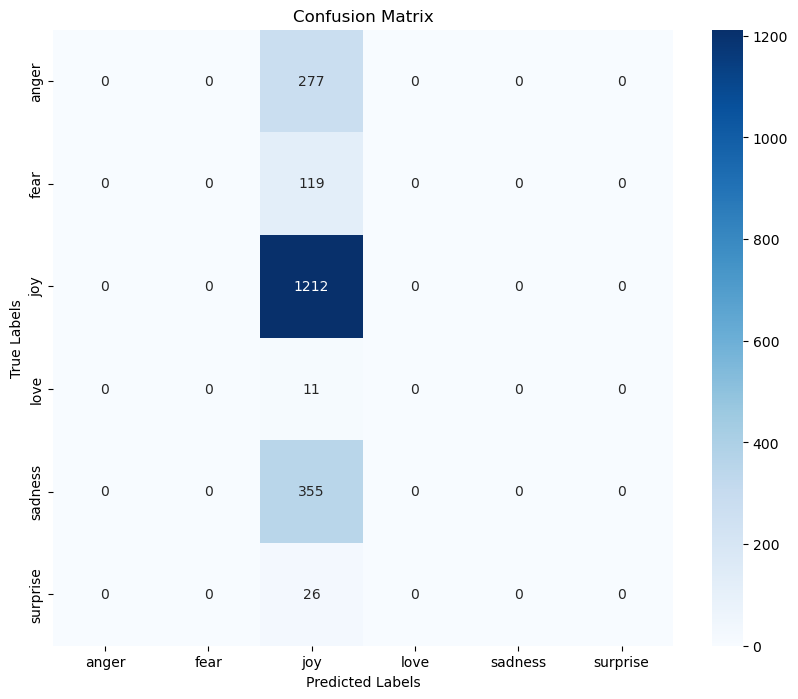

In [13]:

# Compute metrics
metrics = compute_metrics(predictions, true_labels)
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print('\n')
print('Macro Metrics')
print(f"Macro Precision: {metrics['precision']:.4f}")
print(f"Macro Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1']:.4f}")
print('\n')
print('Weighted Metrics')
print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
print(f"Weighted F1 Score: {metrics['f1_weighted']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, label_classes)

In [16]:

# Print classification report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=label_classes))


Classification Report:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       277
        fear       0.00      0.00      0.00       119
         joy       0.61      1.00      0.75      1212
        love       0.00      0.00      0.00        11
     sadness       0.00      0.00      0.00       355
    surprise       0.00      0.00      0.00        26

    accuracy                           0.61      2000
   macro avg       0.10      0.17      0.13      2000
weighted avg       0.37      0.61      0.46      2000



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
